In this notebook, we will breifly discuss few topics which we will be frequently using in subsequent notebooks. The topics include:  

1. Account initialization  
2. Transpilation  
2. Executing circuits with: real backend, ideal simulator, and noisy simulator

# Account initialization

`token` and `instance` can be found at your IBM quantum computing account (https://quantum-computing.ibm.com/account). If you do not have an account yet, please open up a free acount @ https://quantum-computing.ibm.com/

In [1]:
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService

# # save your IBMProvider accout for future loading
# IBMProvider.save_account(instance="your instance", token="your token")

# # save your QiskitRuntimeService accout for future loading
# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     instance="your instance",
#     token="your token"
# )

# Transpilation

Transpilation is a step to convert a high-level quantum circuit to a device compatible one. Typically, quantum circuits are written with high-level gates, e.g., 3-qubit+ gates. One the other hand, real quantum computers have a limited set of native gates (basis gates). For example, `ibm_peekskill` supports single-qubit `ID, SX, X, RX, Delay, Reset` and 2-qubit `CX` gates. Moreover, the devices have limited connectivity meaning the native 2q gate is supported between limited set of *connected* qubits, not between any qubits on the device. Thus, we need a compilation step that will convert the high-level non-compliant circuit such that its gates are decomposed into the native gates of the device as well as properly routed (using SWAP operations) to meet the connectivity constraint of the device. This is where transpiler comes into play. A transpiler does the above-mentioned items as well as performs numerous circuit optimizations such as mapping to low-noise qubits, gate cancellation and intelligent routing to reduce gate counts, and so on.

As each gate operation is noisy in present day quantum computers, it is paramount to have an optimized version (less gates, less depths, etc.) of the final circuit to combat noise to some extent.

Qiskit comes with a built-in compiler (the *transpiler*) which does the above and provides many configuration options. We will discuss the bare minimum options here.

In [2]:
# utility function for fidelity calculation
from qiskit.quantum_info import hellinger_fidelity

# import the transpile function that performs the transpilation
from qiskit import transpile
# import function to create random quantum circuit
from qiskit.circuit.random import random_circuit

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
# create a random circuit
qc = random_circuit(num_qubits=5, depth=3, max_operands=3, measure=True, seed=0)

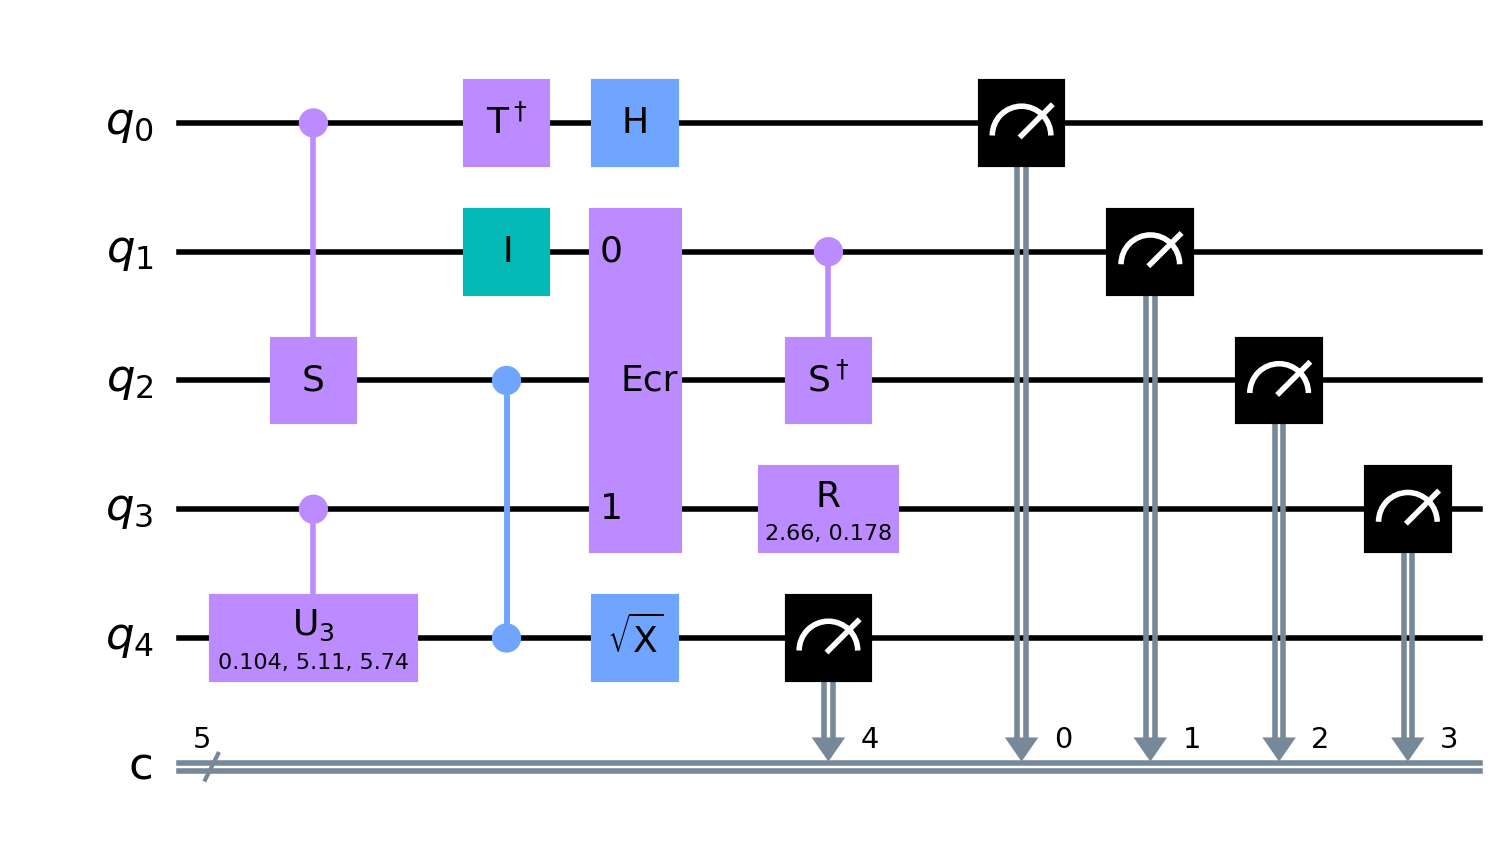

In [4]:
qc.draw("mpl")

In [5]:
qc.count_ops()

OrderedDict([('measure', 5),
             ('cs', 1),
             ('cu3', 1),
             ('id', 1),
             ('tdg', 1),
             ('ecr', 1),
             ('cz', 1),
             ('r', 1),
             ('csdg', 1),
             ('sx', 1),
             ('h', 1)])

## Fetching backend

In [7]:
# fetching backend
# loading the previously saved account
provider = IBMProvider()
backend = provider.get_backend("ibm_brisbane")

In [8]:
backend.operation_names

['if_else',
 'delay',
 'sx',
 'measure',
 'reset',
 'rz',
 'x',
 'id',
 'switch_case',
 'for_loop',
 'ecr']

**ibm_brisbane coupling map**

![ibm_peekskill_calibrations_readout_error_cx_map_2023-07-16T22_00_36Z.svg](imgs/ibm_peekskill_calibrations_readout_error_cx_map_2023-07-16T22_00_36Z.svg)

In [9]:
# bare minimum transpile call
# optimization_level=3 implements preset passes
transpiled_qc = transpile(qc, backend=backend, optimization_level=3)

/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/U

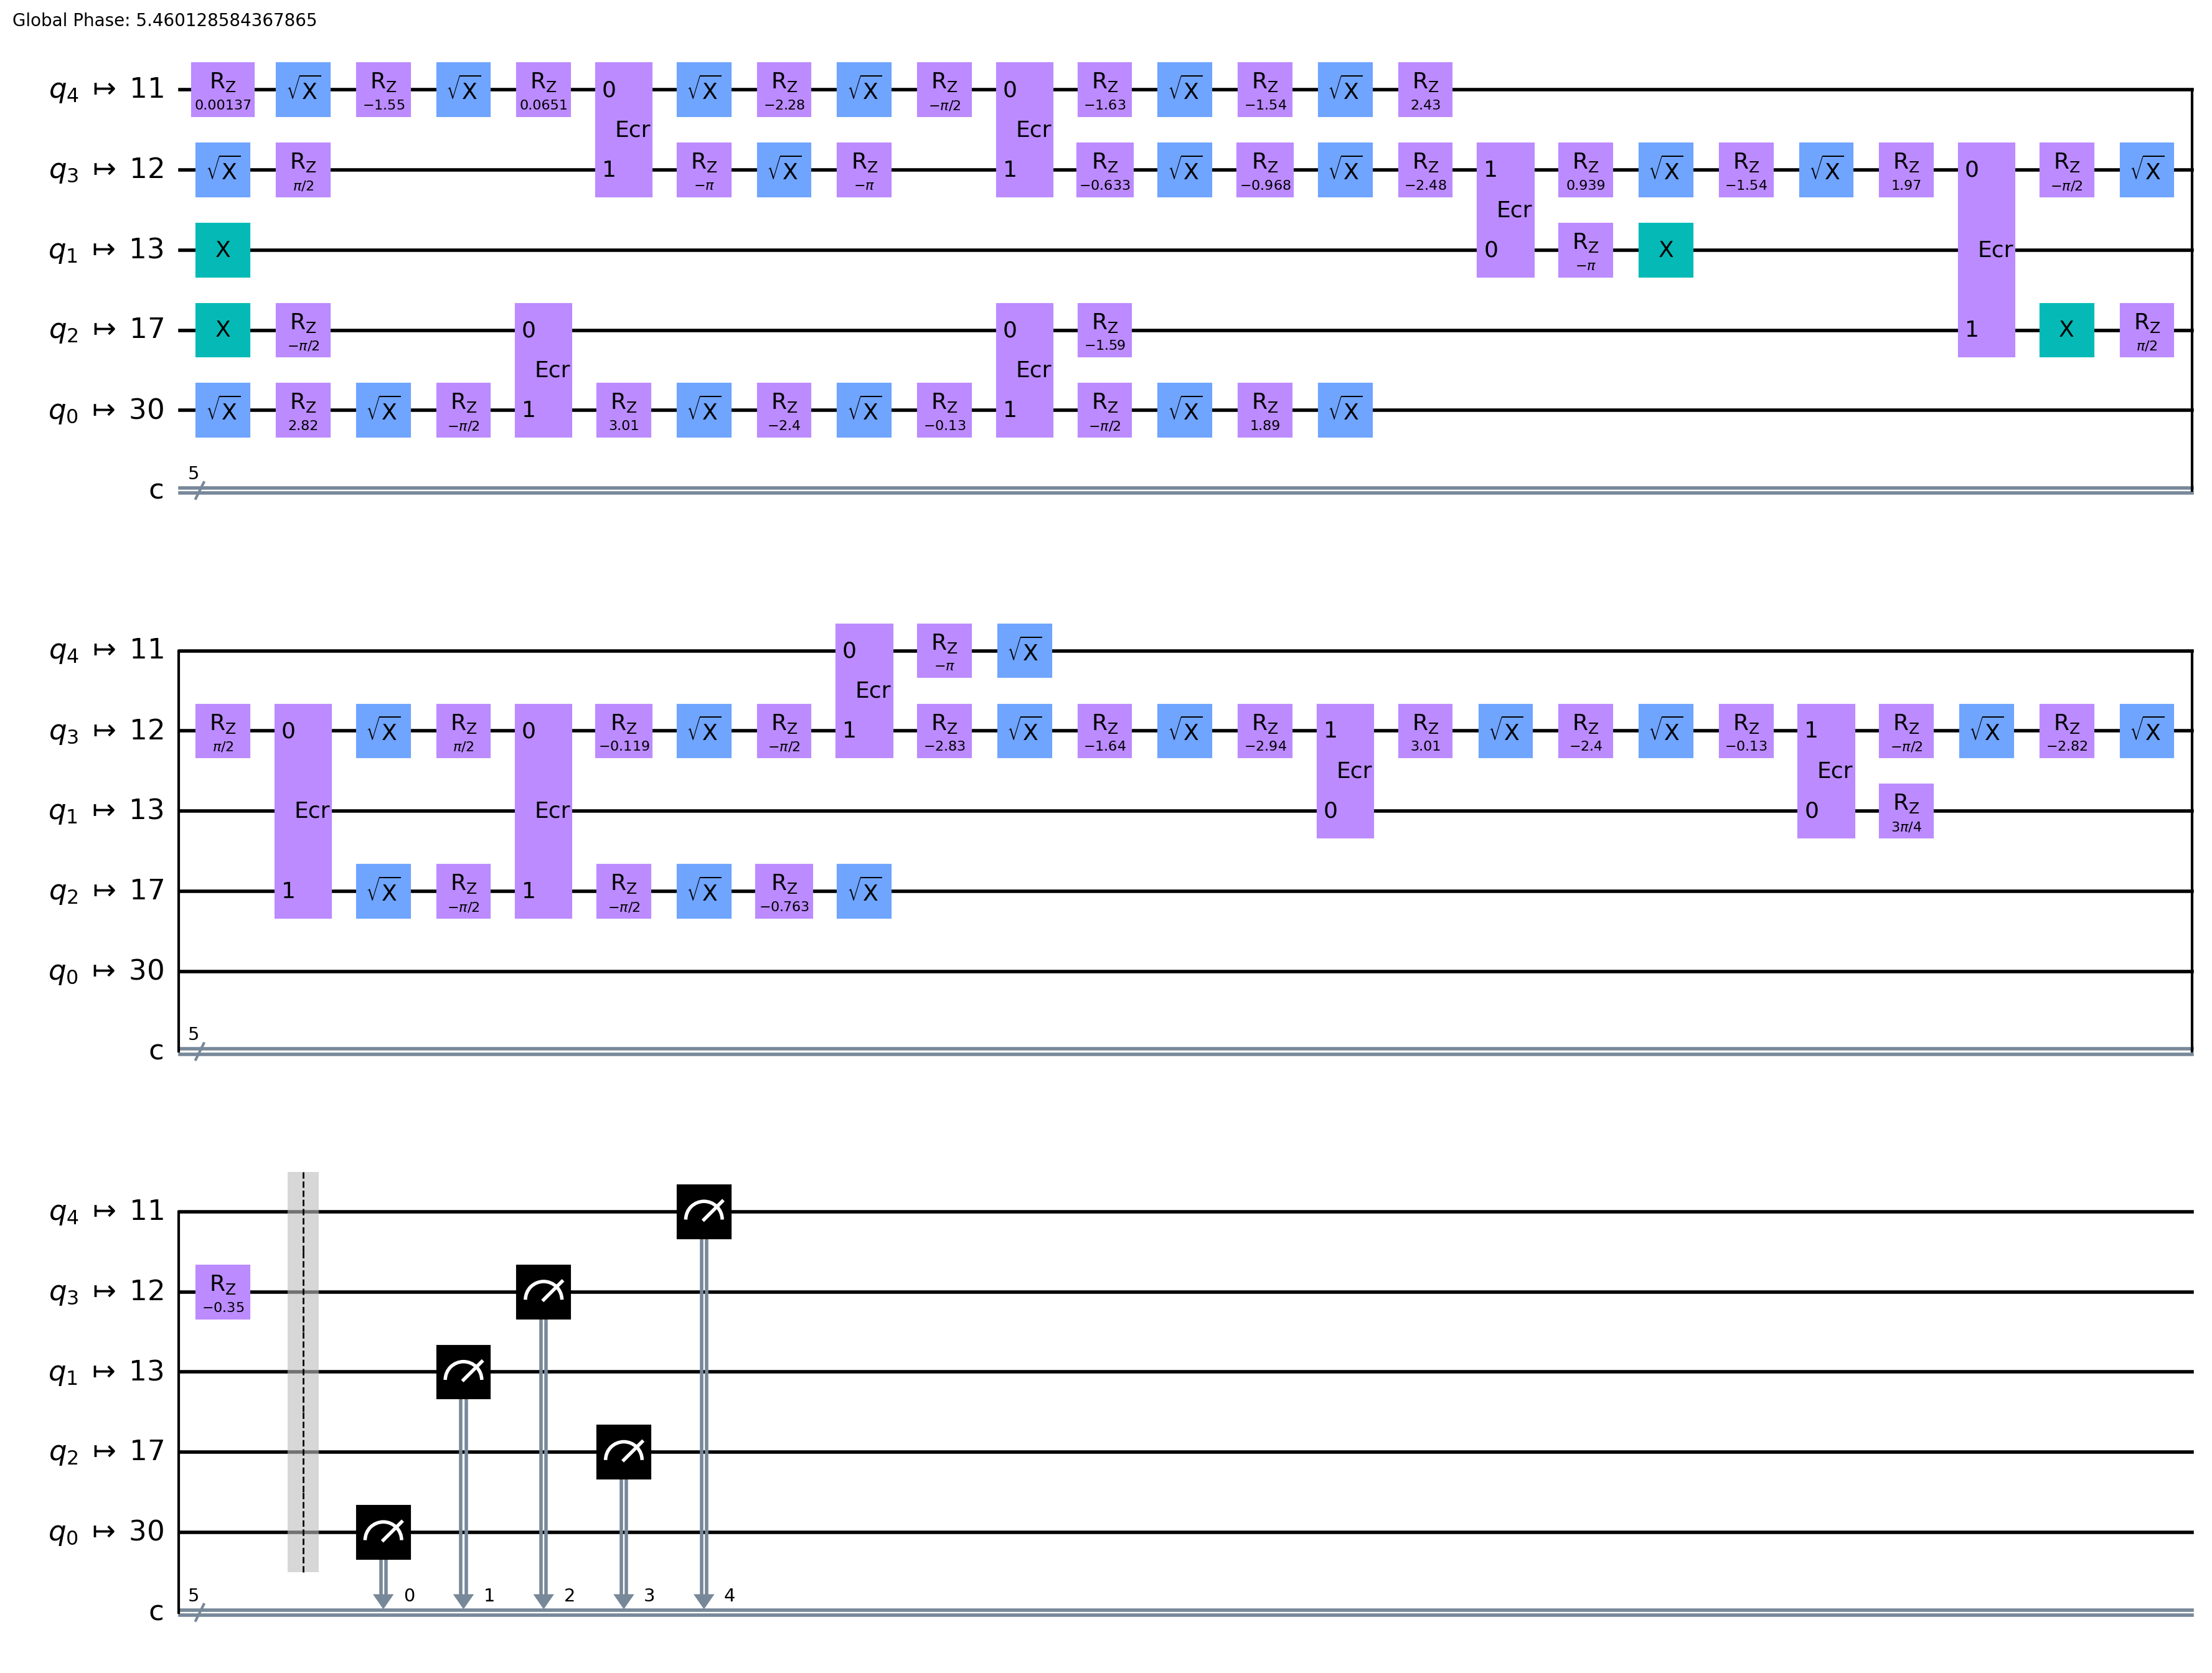

In [10]:
transpiled_qc.draw("mpl", idle_wires=False)

<div class="alert alert-warning">
   <div>
       <big><b>Note</b></big>
   </div>
   <br>
    Note the order of measurement operations which changed due to 1 added SWAP (sequence of 3 alternating CNOTs). SWAP was needed to meet the device's limited connectivity.
</div>

In [11]:
transpiled_qc.count_ops()

OrderedDict([('rz', 47),
             ('sx', 31),
             ('ecr', 11),
             ('measure', 5),
             ('x', 4),
             ('barrier', 1)])

In [12]:
# transpile call with lower optimization_level
# note the elevated gate counts compared to level 3
transpiled_qc0 = transpile(qc, backend=backend, optimization_level=0)
transpiled_qc0.count_ops()

OrderedDict([('rz', 270),
             ('sx', 116),
             ('ecr', 21),
             ('x', 20),
             ('measure', 5),
             ('id', 1),
             ('barrier', 1)])

# Ideal Simulator

In [13]:
# import from qiskit-aer module
from qiskit_aer import AerSimulator

In [14]:
ideal_simulator = AerSimulator()

## Running a circuit with ideal simulator

In [15]:
ideal_counts = ideal_simulator.run(transpiled_qc, shots=10000).result().get_counts()
ideal_counts

{'01011': 1815,
 '10010': 676,
 '01010': 1818,
 '11011': 1796,
 '00010': 680,
 '10011': 690,
 '00011': 698,
 '11010': 1827}

# Noisy Simulator

We can configure a noisy simulator with a real hardware's noise model with ease.

In [16]:
noisy_simulator = AerSimulator.from_backend(backend)

AttributeError: Attribute description is not defined

In [ ]:
noisy_counts = noisy_simulator.run(transpiled_qc, shots=10000).result().get_counts()
noisy_counts

{'01010': 1720,
 '10001': 11,
 '11010': 1705,
 '10010': 625,
 '11011': 1814,
 '00010': 623,
 '01011': 1663,
 '10011': 628,
 '00011': 651,
 '01101': 11,
 '10000': 11,
 '11111': 66,
 '00111': 31,
 '00110': 31,
 '01000': 24,
 '01111': 65,
 '01110': 63,
 '11000': 27,
 '01001': 25,
 '11001': 19,
 '11110': 74,
 '10111': 37,
 '00100': 6,
 '11100': 6,
 '00000': 8,
 '10100': 4,
 '00001': 10,
 '10110': 22,
 '11101': 6,
 '01100': 8,
 '00101': 3,
 '10101': 3}

In [ ]:
hellinger_fidelity(ideal_counts, noisy_counts)

0.9421304149792338

# Running on a real Backend

<div class="alert alert-warning">
   <div>
       <big><b>Real Hardware Run</b></big>
   </div>
   <br>
    For the sake of time, you may skip running on real backend during the workshop.
</div>

In [18]:
# Note backend.run() always require `transpiled` circuit
real_counts = backend.run(transpiled_qc, shots=10000).result().get_counts()
real_counts

{'00000': 18,
 '00001': 14,
 '10000': 11,
 '10001': 10,
 '10010': 860,
 '10011': 768,
 '10100': 5,
 '10101': 10,
 '10110': 66,
 '10111': 44,
 '11000': 28,
 '11001': 37,
 '11010': 1936,
 '11011': 1860,
 '11100': 9,
 '11101': 10,
 '11110': 77,
 '11111': 84,
 '00010': 628,
 '00011': 568,
 '00100': 5,
 '00101': 6,
 '00110': 48,
 '00111': 58,
 '01000': 17,
 '01001': 16,
 '01010': 1372,
 '01011': 1289,
 '01100': 10,
 '01101': 11,
 '01110': 51,
 '01111': 74}

In [19]:
hellinger_fidelity(ideal_counts, real_counts)

0.9168985730546235

# Fake Backend

In [17]:
from qiskit.providers.fake_provider import FakeMumbai, FakeHanoiV2

In [18]:
fake_backend = FakeMumbai()

In [19]:
transpiled_qc = transpile(qc, backend=fake_backend, optimization_level=3)

/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [20]:
fake_backend_counts = fake_backend.run(transpiled_qc, shots=10000).result().get_counts()
fake_backend_counts

{'00101': 1,
 '10101': 2,
 '00100': 2,
 '11100': 2,
 '10110': 17,
 '00000': 38,
 '11101': 4,
 '00110': 32,
 '11111': 46,
 '10001': 41,
 '01000': 90,
 '11000': 89,
 '11110': 64,
 '10100': 1,
 '00111': 14,
 '10011': 672,
 '01110': 59,
 '01001': 93,
 '11011': 1610,
 '01111': 55,
 '11010': 1628,
 '00001': 41,
 '00011': 647,
 '01011': 1549,
 '01100': 8,
 '10010': 687,
 '01101': 3,
 '10111': 24,
 '01010': 1649,
 '11001': 97,
 '10000': 42,
 '00010': 693}

In [21]:
hellinger_fidelity(ideal_counts, fake_backend_counts)

0.9128211741139651

In [22]:
import numpy
print(f"numpy version {numpy.__version__}")

import qiskit_ibm_runtime
print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")

import qiskit.tools.jupyter
%qiskit_version_table

numpy version 1.23.5
qiskit runtime version 0.13.0
